# Wuzzuf Job Market Analysis - Exploratory Data Analysis

This notebook performs comprehensive analysis to answer 6 key business questions about the job market using the cleaned and processed Wuzzuf job postings data stored in PostgreSQL.

## Business Questions:
1. What are the most common job titles and hiring industries?
2. What are the top technical and soft skills in demand?
3. How are experience requirements distributed across the job market?
4. What are the salary trends by role, industry, and experience level?
5. Which locations have the highest job posting volumes?
6. What are the monthly posting trends over time?


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import sys
import os
from pathlib import Path

# Add sql directory to path for database utilities
sys.path.append('../sql')
from database_setup import DatabaseManager

# Configure display and warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create charts directory if it doesn't exist
charts_dir = Path('../assets/charts')
charts_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")
print(f"Charts will be saved to: {charts_dir.absolute()}")

Libraries imported successfully
Charts will be saved to: c:\Users\hp\Downloads\wuzuf-analysis\notebooks\..\assets\charts


In [2]:
# Initialize database connection
print("Connecting to PostgreSQL database...")

try:
    db_manager = DatabaseManager()
    engine = db_manager.get_engine()
    
    # Test connection
    status = db_manager.test_connection()
    print(f"✅ Connected to database: {status['database']}")
    print(f"📊 Tables available: {status['table_count']}")
    
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    print("Please ensure PostgreSQL is running and database is set up correctly")
    raise

2025-08-14 21:46:46,818 - INFO - Database connection established successfully


Connecting to PostgreSQL database...
✅ Connected to database: wuzzuf
📊 Tables available: 6


In [3]:
# Get overview of database tables and data
print("Database Overview:")
print("=" * 50)

# Check table row counts
tables = ['jobs', 'companies', 'skills', 'job_skills']
for table in tables:
    try:
        count_query = f"SELECT COUNT(*) as count FROM {table}"
        result = pd.read_sql(count_query, engine)
        count = result['count'].iloc[0]
        print(f"📋 {table}: {count:,} records")
    except Exception as e:
        print(f"❌ Error querying {table}: {e}")

print("\n" + "=" * 50)

Database Overview:
📋 jobs: 25,114 records
📋 companies: 4,468 records
📋 skills: 167 records
📋 job_skills: 159,894 records



## Analysis 1: Top Roles and Industries

**Business Question:** What are the most common job titles and hiring industries?

This analysis identifies the job roles with the highest demand and the industries posting the most jobs, providing insights into market opportunities and hiring trends.

In [4]:
# Analysis 1: Top Roles and Industries
print("🔍 Analysis 1: Top Roles and Industries")
print("=" * 50)

# SQL query for top 10 job titles by posting count
top_roles_query = """
SELECT 
    job_title,
    COUNT(*) as posting_count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM jobs), 2) as percentage
FROM jobs 
WHERE job_title IS NOT NULL 
    AND job_title != ''
GROUP BY job_title 
ORDER BY posting_count DESC 
LIMIT 10;
"""

# Execute query and display results
top_roles_df = pd.read_sql(top_roles_query, engine)
print("📊 Top 10 Job Titles by Posting Count:")
print(top_roles_df.to_string(index=False))

print("\n" + "-" * 50)

# SQL query for top 10 industries by posting volume
top_industries_query = """
SELECT 
    c.industry,
    COUNT(j.job_id) as posting_count,
    ROUND(COUNT(j.job_id) * 100.0 / (SELECT COUNT(*) FROM jobs), 2) as percentage
FROM jobs j
JOIN companies c ON j.company_id = c.company_id
WHERE c.industry IS NOT NULL 
    AND c.industry != ''
GROUP BY c.industry 
ORDER BY posting_count DESC 
LIMIT 10;
"""

# Execute query and display results
top_industries_df = pd.read_sql(top_industries_query, engine)
print("🏢 Top 10 Industries by Posting Volume:")
print(top_industries_df.to_string(index=False))

🔍 Analysis 1: Top Roles and Industries
📊 Top 10 Job Titles by Posting Count:
                    job_title  posting_count  percentage
            software engineer           8112       32.30
                data engineer           3462       13.79
             business analyst           2009        8.00
               data scientist           1999        7.96
                    developer           1502        5.98
                 data analyst           1485        5.91
                ux researcher            897        3.57
software development engineer            506        2.01
              product manager            481        1.92
               senior analyst            463        1.84

--------------------------------------------------
🏢 Top 10 Industries by Posting Volume:
                         industry  posting_count  percentage
                         internet           5055       20.13
                computer software           4720       18.79
information technology

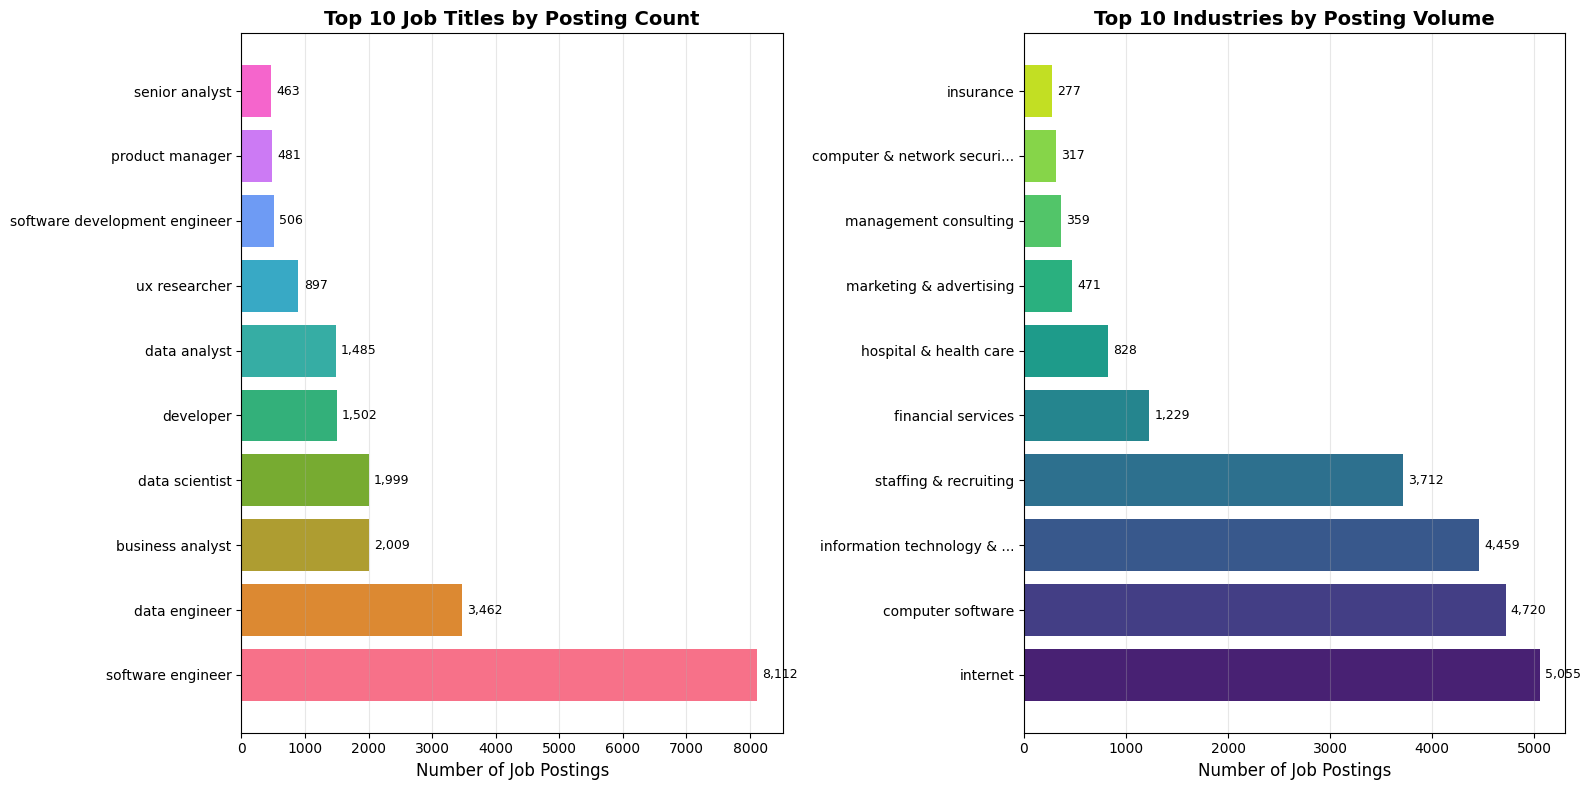


📈 Chart saved to: ../assets/charts/top_roles_industries.png


In [5]:
# Create visualization for top roles and industries
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Top Roles Bar Chart
ax1.barh(range(len(top_roles_df)), top_roles_df['posting_count'], 
         color=sns.color_palette("husl", len(top_roles_df)))
ax1.set_yticks(range(len(top_roles_df)))
ax1.set_yticklabels([title[:30] + '...' if len(title) > 30 else title 
                     for title in top_roles_df['job_title']], fontsize=10)
ax1.set_xlabel('Number of Job Postings', fontsize=12)
ax1.set_title('Top 10 Job Titles by Posting Count', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(top_roles_df['posting_count']):
    ax1.text(v + max(top_roles_df['posting_count']) * 0.01, i, f'{v:,}', 
             va='center', fontsize=9)

# Top Industries Bar Chart
ax2.barh(range(len(top_industries_df)), top_industries_df['posting_count'],
         color=sns.color_palette("viridis", len(top_industries_df)))
ax2.set_yticks(range(len(top_industries_df)))
ax2.set_yticklabels([industry[:25] + '...' if len(industry) > 25 else industry 
                     for industry in top_industries_df['industry']], fontsize=10)
ax2.set_xlabel('Number of Job Postings', fontsize=12)
ax2.set_title('Top 10 Industries by Posting Volume', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(top_industries_df['posting_count']):
    ax2.text(v + max(top_industries_df['posting_count']) * 0.01, i, f'{v:,}', 
             va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../assets/charts/top_roles_industries.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📈 Chart saved to: ../assets/charts/top_roles_industries.png")

In [6]:
# Generate business insights for top roles and industries
print("💡 Business Insights - Top Roles and Industries:")
print("=" * 60)

# Get key metrics
top_role = top_roles_df.iloc[0]['job_title']
top_role_count = top_roles_df.iloc[0]['posting_count']
top_role_pct = top_roles_df.iloc[0]['percentage']

top_industry = top_industries_df.iloc[0]['industry']
top_industry_count = top_industries_df.iloc[0]['posting_count']
top_industry_pct = top_industries_df.iloc[0]['percentage']

# Generate insights
insight_1 = f"The most in-demand job title is '{top_role}' with {top_role_count:,} postings ({top_role_pct}% of all jobs), indicating strong market demand for this role."

insight_2 = f"The '{top_industry}' industry leads in hiring activity with {top_industry_count:,} job postings ({top_industry_pct}% of total), suggesting significant growth and expansion in this sector."

# Calculate diversity metrics
top_5_roles_pct = top_roles_df.head(5)['percentage'].sum()
top_5_industries_pct = top_industries_df.head(5)['percentage'].sum()

insight_3 = f"The top 5 job titles represent {top_5_roles_pct}% of all postings while the top 5 industries account for {top_5_industries_pct}%, showing {'high' if top_5_roles_pct > 50 else 'moderate'} market concentration in key roles and industries."

print(f"1. {insight_1}")
print(f"\n2. {insight_2}")
print(f"\n3. {insight_3}")

# Store insights for summary
analysis_1_insights = [insight_1, insight_2, insight_3]

print("\n✅ Analysis 1 completed successfully!")

💡 Business Insights - Top Roles and Industries:
1. The most in-demand job title is 'software engineer' with 8,112 postings (32.3% of all jobs), indicating strong market demand for this role.

2. The 'internet' industry leads in hiring activity with 5,055 job postings (20.13% of total), suggesting significant growth and expansion in this sector.

3. The top 5 job titles represent 68.03% of all postings while the top 5 industries account for 76.35000000000001%, showing high market concentration in key roles and industries.

✅ Analysis 1 completed successfully!
